# IBM AI Enterprise Workflow Capstone Project

## Part 1



#### 1) Assimilate the business scenario and articulate testable hypotheses

The data has transaction-level purchases across 38 different countries. A service is required to predict revenue for the following month and Service should have ability to project revenue for a specific country.

Business scenario here is that the management team expects to spend less time in projection models and gain more accuracy in forecasting revenue. It is expected that well projected numbers will help stabilize staffing and budget projections which will have a beneficial ripple effect throughout the company.

Business metric can be defined as a function of revenue gained through more accurate predictions. 

Null Hypothesis: Improved accuracy has no effect on the revenue of the company

Therefore, a hypothesis testing can be carried out to reject the null hypothesis. 

#### 2) State the ideal data to address the business opportunity and clarify the rationale for needing specific data.

The ideal data would contain a feature set based on which the revenue of the AAVAIL could be predicted such as the number of subscribers, types of subscription, location etc and the target variable would be the revenue. This will help in building a supervised learning pipeline which would be predicting the target variable "Revenue" based on the feature set or dependent variables. 

An alternative scenario would be the application of time-series analysis where the revenue of AAVAIL is given alongwith the timestamp. Thus, a timeseries forecasting technique could be applied to obtain the budget projection based on the historical data. 

#### 3) Create a python script to extract relevant data from multiple data sources, automating the process of data ingestion.

In [1]:
import re, io
import os, json
import pandas as pd
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
%matplotlib inline

##### Data Ingestion and Preprocessing

In order to leverage data to solve the business problem at hand, it is first required to be understood. One of the json files from the cs-train folder is read in order to know the informations that are available in the data. 

In [2]:
with open('../cs-train/invoices-2018-11.json', 'r') as f:
    data = json.load(f)
sample_df = pd.DataFrame(data)
sample_df.head()

,country,customer_id,invoice,price,StreamID,TimesViewed,year,month,day
0,United Kingdom,NaN,530850,1.66,22578,1,2018,11,01
1,United Kingdom,NaN,530850,3.36,22549,1,2018,11,01
2,United Kingdom,NaN,530850,3.36,22557,1,2018,11,01
3,United Kingdom,NaN,530850,2.51,22567,1,2018,11,01
4,United Kingdom,NaN,530850,3.36,22553,1,2018,11,01


It can be seen that each json file represents a monthly data of AAVAIL's transaction for different countries. The various features availabe in the data are "TimesViewed", "country", "customer_id", "day", "invoice", "month", "total_price" and "year" alongwith a unique stream id. These can be used to create a dataframe which will then be used to merge all data of all the months to create one single dataframe.

#### Quality Assurance step
In order to make sure that the data passes quality control check, a few tests are created in order to check the column name for consistency because otherwise it would not be possible to create a unified dataframe and do further analysis.
The data also needs to be sorted in a chronological order to carry out a predictive or forecasting analysis.

Importing variables from the module

In [3]:
from variables import init_variables
path_to_json, column_dict, inconsistent_col, keys = init_variables()

Importing functions from the module

In [4]:
from data_ingestor import *

In [5]:
master_df = read_all_json_files(path_to_json, column_dict, inconsistent_col, keys)
master_df.head()

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year
0,United Kingdom,13085.0,28,489434,11,6.95,85048,12,2017
1,United Kingdom,NaN,28,489597,11,8.65,22130,1,2017
2,United Kingdom,NaN,28,489597,11,1.70,22132,6,2017
3,United Kingdom,NaN,28,489597,11,1.70,22133,4,2017
4,United Kingdom,NaN,28,489597,11,0.87,22134,1,2017


Data type of data in all the columns is checked in order to make sure further steps can be carried out with ease

In [6]:
master_df.dtypes

country          object
customer_id     float64
day              object
invoice          object
month            object
price           float64
stream_id        object
times_viewed     object
year             object
dtype: object

In order to maintain the quality of data, following columns should be of these data types:

{ country: string, customer_id: integer, day: integer, invoice: integer, month: integer,
price: float64, stream_id: integer, times_viewed: integer, year: integer}

In [7]:
master_df_clean = maintain_datatype(master_df)
master_df_clean.dtypes

country          object
customer_id     float64
day               int64
invoice          object
month             int64
price           float64
stream_id        object
times_viewed      int64
year              int64
dtype: object

In [8]:
master_df_clean.shape

(815011, 9)

Dropping rows where invoice id is not a number in order to facilitate better matching. 

In [9]:
master_df_clean = drop_non_numeric_invoice(master_df_clean)
master_df_clean.shape

(799544, 9)

In [10]:
# Number of unique invoice ids
master_df_clean['invoice'].nunique()

35874

Aggregating records based on the invoice id so that each record contains the sum of the price and times viewed for each invoice

In [11]:
master_df_agg = master_df_clean.groupby(['invoice']).agg({'times_viewed':'sum', 'price':'sum',
                                        'country':'first', 'day':'first',
                                        'month':'first', 'year':'first'}).reset_index()
master_df_agg.head()

,invoice,times_viewed,price,country,day,month,year
0,489434,103,32.65,United Kingdom,28,11,2017
1,489435,54,10.50,United Kingdom,28,11,2017
2,489436,165,70.88,United Kingdom,28,11,2017
3,489437,145,83.45,United Kingdom,28,11,2017
4,489438,214,44.05,United Kingdom,28,11,2017


#### 4) Investigate the relationship between the relevant data, the target and the business metric.

#### Exploratory Data Analysis

It is during the Exploratory Data Analysis (EDA) process that data integrity issues are identified sometimes.

After extracting data it is important to include checks for quality assurance even on the first pass through the AI workflow.  Let's combine the data into a single structure and provide a couple checks for quality assurance.

**Implementation of checks for Quality Assurance**

- Remove any repeat customers based on customer_id
- Check for missing values

In [12]:
print("Cleaning Summary\n{}".format("-"*50))
print("Total records:", master_df_clean.shape[0])
duplicate_rows = master_df_clean.duplicated()
if True in duplicate_rows:
    master_df_clean = master_df_clean[~duplicate_rows]
print("Removed {} duplicate rows".format(np.where(duplicate_rows==True)[0].size))

print("\nMissing Value Summary\n{}".format("-"*50))
print("\nmaster_df\n{}".format("-"*25))
print(master_df_clean.isnull().sum(axis = 0))

Cleaning Summary
--------------------------------------------------
Total records: 799544
Removed 28757 duplicate rows

Missing Value Summary
--------------------------------------------------

master_df
-------------------------
country              0
customer_id     181565
day                  0
invoice              0
month                0
price                0
stream_id            0
times_viewed         0
year                 0
dtype: int64


#### Top 10 countries in terms of revenue

In [13]:
# List of countries in terms of revenue
countries_sum = master_df_clean.groupby(['country'])['price'].sum()
# Top 10 countries from sorted list of countries in decreasing order
top_10 = countries_sum.sort_values(ascending=False)[0:10]
top_10

country
United Kingdom    2.900369e+06
EIRE              7.789082e+04
Germany           4.314842e+04
France            3.622131e+04
Norway            1.761478e+04
Spain             1.136122e+04
Netherlands       1.054226e+04
Belgium           9.483260e+03
Portugal          9.406770e+03
Switzerland       9.002320e+03
Name: price, dtype: float64

##### Selecting only top 10 countries for further analysis

In [14]:
list_top_10 = ['United Kingdom', 'EIRE', 'Germany', 'France', 'Norway', 'Spain', 'Hong Kong', 'Portugal', 'Singapore',
               'Netherlands']
top_10_df = master_df_clean[master_df_clean['country'].isin(list_top_10)]
top_10_df.shape

(754349, 9)

In [15]:
top_10_df.head()

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year
0,United Kingdom,13085.0,28,489434,11,6.95,85048,12,2017
1,United Kingdom,NaN,28,489597,11,8.65,22130,1,2017
2,United Kingdom,NaN,28,489597,11,1.70,22132,6,2017
3,United Kingdom,NaN,28,489597,11,1.70,22133,4,2017
4,United Kingdom,NaN,28,489597,11,0.87,22134,1,2017


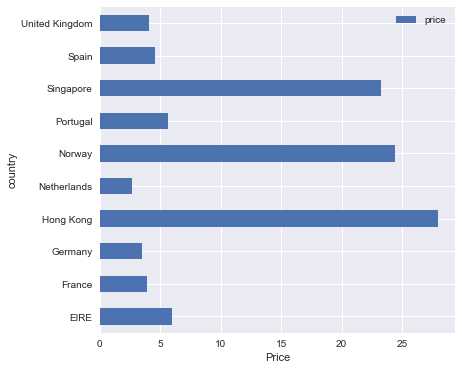

In [16]:
fig = plt.figure(figsize=(14,6))
ax2 = fig.add_subplot(121)

bar_plot = pd.pivot_table(top_10_df, index = ['country'], values = 'price')
bar_plot.plot(kind='barh',ax=ax2)
ax2.set_xlabel("Price");

The above plot represents price on X-axis for each of the top 10 revenue earning countries

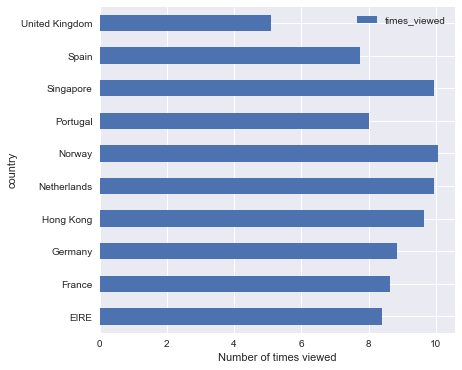

In [17]:
fig = plt.figure(figsize=(14,6))
ax2 = fig.add_subplot(121)

bar_plot = pd.pivot_table(top_10_df, index = ['country'], values = 'times_viewed')
bar_plot.plot(kind='barh',ax=ax2)
ax2.set_xlabel("Number of times viewed");

The above plot represents number of times video viewed on X-axis for each of the top 10 revenue earning countries

(0.0, 9.3)

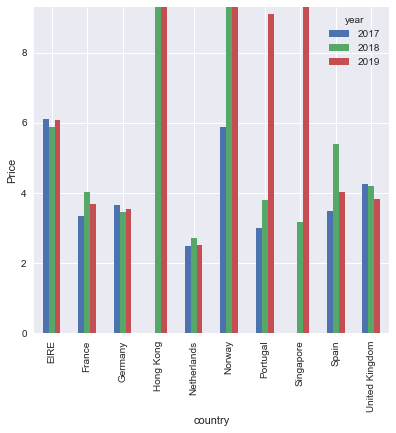

In [18]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)

bar_plot = pd.pivot_table(top_10_df,index='country',columns='year',values="price")
bar_plot.plot(kind='bar',ax=ax1)
ax1.set_ylabel("Price");

## adjust the axis to accomadate the legend
ax1.set_ylim((0,9.3))

(0.0, 9.3)

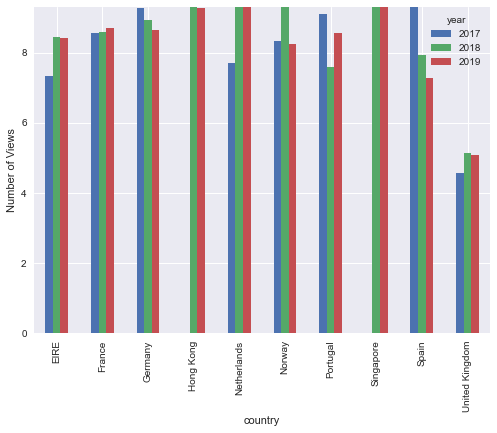

In [19]:
fig = plt.figure(figsize=(18,6))
ax2 = fig.add_subplot(121)

bar_plot = pd.pivot_table(top_10_df,index='country',columns='year',values="times_viewed")
bar_plot.plot(kind='bar',ax=ax2)
ax2.set_ylabel("Number of Views");

## adjust the axis to accomadate the legend
ax2.set_ylim((0,9.3))

/Users/aishwarya.das1ibm.com/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/aishwarya.das1ibm.com/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


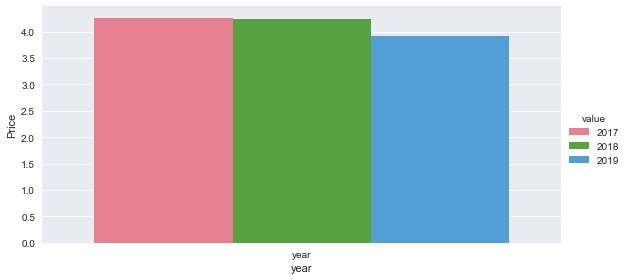

In [20]:
# Create a new temporary dataframe to help us plot these variables.
temp_df = pd.melt(top_10_df, id_vars=['price'], value_vars=["year"], var_name='year' )

# Create a factorplot
factor_plot = sns.factorplot( x="year", y="price", hue='value', data=temp_df, size=4, aspect=2, kind="bar", palette="husl", ci=None )
factor_plot.despine(left=True)
factor_plot.set_ylabels("Price")
plt.show()

#### 5) Articulate your findings using a deliverable with visualizations.

For a supervised learning pipeline, the target variable would be 'price'.
Important feature determining price appears to be 'times_viewed' which represents the number of times video streams were viewed. A country wise analysis would make the feature 'country' important since grouping by would be done on that column. 


'year' and 'month' would be a feature for carrying out time-series forecasting of the revenue. 

In [21]:
master_df_agg.head()

,invoice,times_viewed,price,country,day,month,year
0,489434,103,32.65,United Kingdom,28,11,2017
1,489435,54,10.50,United Kingdom,28,11,2017
2,489436,165,70.88,United Kingdom,28,11,2017
3,489437,145,83.45,United Kingdom,28,11,2017
4,489438,214,44.05,United Kingdom,28,11,2017


#####  Time Series forecasting data preparation:

In order to carry out a time series analysis, record of each day should be considered and the dataframe should be in a chronological order so that forecasting models can fit and provide revenue i.e price for the following month. Let's start by aggregating the transactions by day

In [22]:
df_day = top_10_df.groupby(['year', 'month', 'day']).agg({'times_viewed':'sum', 'price':'sum',
                                        'country':'first',}).reset_index()
df_day.head()

,year,month,day,times_viewed,price,country
0,2017,11,28,14673,13608.29,United Kingdom
1,2017,11,29,14044,13088.49,United Kingdom
2,2017,11,30,15445,11050.81,United Kingdom
3,2017,12,1,12012,9270.88,United Kingdom
4,2017,12,2,3101,1263.28,United Kingdom


Now the data has been arranged in the chronological order, so it can be used in time-series forecasting model in order to project revenue for the following month. Given dataframe in this form, forecasted results would produce the price or "revenue" for each day based on the features provided to the model. In order to gain monthly revenue, we need to aggregate the data by month rather than day.

In [23]:
print("Total number of days in considerdation for analysis:", df_day.shape[0])

Total number of days in considerdation for analysis: 495


In [24]:
df_month = top_10_df.groupby(['year', 'month']).agg({'times_viewed':'sum', 'price':'sum',
                                        'country':'first',}).reset_index()
df_month.head()

,year,month,times_viewed,price,country
0,2017,11,44162,37747.590,United Kingdom
1,2017,12,159574,146710.260,United Kingdom
2,2018,1,169153,153775.324,United Kingdom
3,2018,2,150951,103125.744,United Kingdom
4,2018,3,194356,192786.491,United Kingdom


The deliverables here are the dataframes 'df_month' and 'df_day' that can be used for forecasting monthly and daily revenue respectively

##### Stationarity check of a time-series

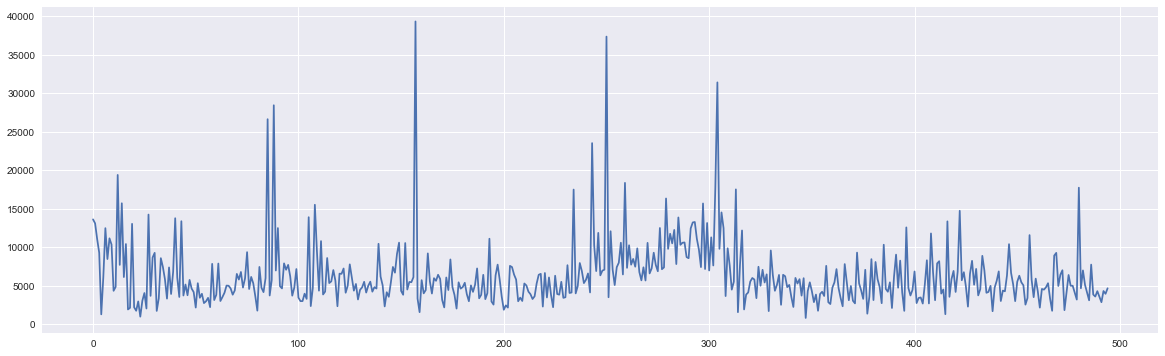

In [25]:
# checking stationarity of a time-series on a daily basis
ts_day = df_day['price']
ts_day.plot(figsize=(20, 6))

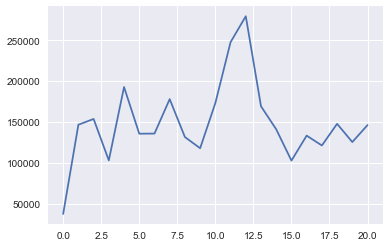

In [26]:
# checking stationarity of a time-series on a monthly basis
ts_month = df_month['price']
plt.plot(ts_month)

In [27]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

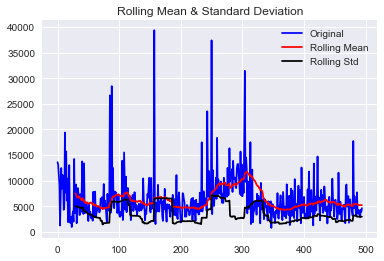

Results of Dickey-Fuller Test:
Test Statistic                  -4.249582
p-value                          0.000543
#Lags Used                       8.000000
Number of Observations Used    486.000000
Critical Value (1%)             -3.443877
Critical Value (5%)             -2.867505
Critical Value (10%)            -2.569947
dtype: float64


In [28]:
test_stationarity(ts_day)

For carrying out time-series forecasting, the Test statistic value is even smaller than 1% of the critical value. Therefore, it can be concluded that the time-series is stationary.


##### Forecasting a time-series

In [29]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_day, nlags=20)
lag_pacf = pacf(ts_day, nlags=20, method='ols')

/Users/aishwarya.das1ibm.com/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


In [30]:
def log_shift(data, shift):
    ts_log = np.log(data)
    ts_log_diff = ts_log - ts_log.shift(shift)
    ts_log_diff = ts_log_diff.dropna()
    ts_log_diff = pd.Series(ts_log_diff.values ,index= ts_log_diff.index)
    return ts_log, ts_log_diff

In [31]:
## Applying ACF and PACF 
ts_log, ts_log_diff = log_shift(ts_day, 1)
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

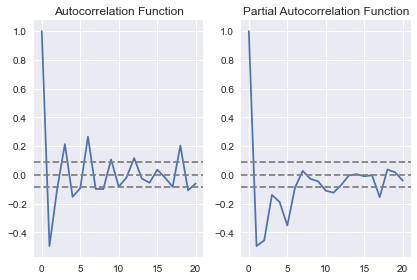

In [32]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

p – The lag value where the PACF chart crosses the upper confidence interval for the first time which appears to be p=8.

q – The lag value where the ACF chart crosses the upper confidence interval for the first time which is q=8.

Text(0.5, 1.0, 'RSS: 134.2344')

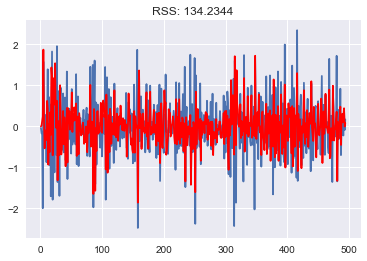

In [33]:
from statsmodels.tsa.arima_model import ARIMA

# AR MODEL
model = ARIMA(ts_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))